In [1]:
from PIL import Image 
import numpy as np 
import torch
import torchvision
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
import supervision as sv 
import torch.nn.functional as F

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

In [4]:
img = Image.open('Contemporary-Modern-House-Design-6.1539270983.8601.jpg')
print(img.size)

(1240, 800)


In [5]:
##encode prompt
img_encode = processor(images=[img], return_tensors="pt")
prompts  = ['trees','sky']

In [6]:
from torch import nn 

In [7]:
inputs = processor(text=prompts,images=[img]*len(prompts),padding='max_length',return_tensors='pt')
#predict
with torch.no_grad():
    outputs = model(**inputs)
preds = nn.functional.interpolate(outputs.logits.unsqueeze(1),size=(img.size[1],img.size[0]),mode='bilinear')

In [8]:
import matplotlib.pyplot as plt

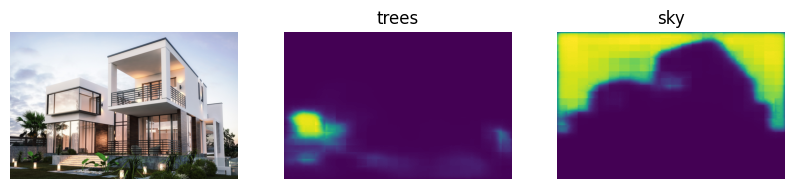

In [9]:
#plot
fig,ax = plt.subplots(1,len(prompts)+1,figsize=(10,7))
ax[0].imshow(img)
ax[0].axis('off')
for i in range(len(prompts)):
    ax[i+1].imshow(torch.sigmoid(preds[i][0]))
    ax[i+1].set_title(prompts[i])
    ax[i+1].axis('off')
plt.show()

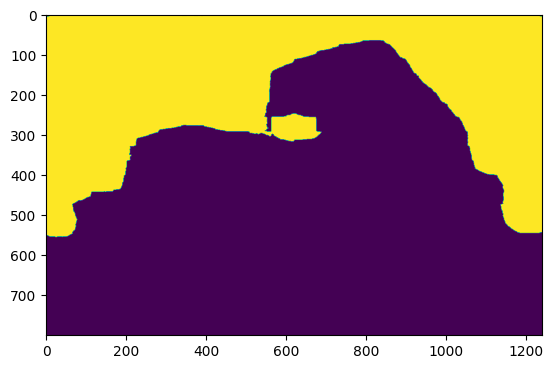

In [24]:
#take one of the outputs and threshold it
threshold = 0.1
pred = torch.sigmoid(preds[1][0])
pred = (pred > threshold).float()
plt.imshow(pred)

In [12]:
import random 

In [13]:
def sample_points_based_on_preds(preds, N):
    height, width = preds.shape
    weights = preds.ravel()
    indices = np.arange(height * width)

    # Randomly sample N indices based on the weights
    sampled_indices = random.choices(indices, weights=weights, k=N)

    # Convert the sampled indices into (col, row) coordinates
    sampled_points = [(index % width, index // width) for index in sampled_indices]

    return sampled_points


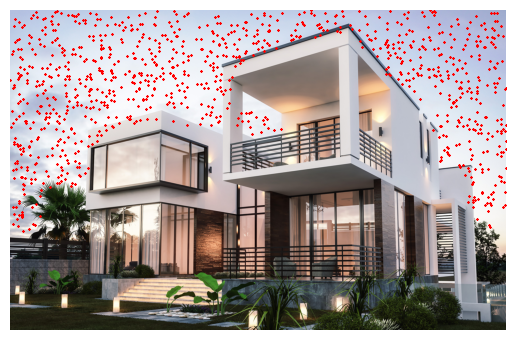

In [26]:
#sample points
sampled_points = sample_points_based_on_preds(pred, 1000)

#plot
_,ax = plt.subplots()
ax.imshow(img)
x,y = zip(*sampled_points)
ax.scatter(x,y,s=1,c='r',marker='x')
ax.axis('off')
plt.show()

In [15]:
def upsample_pred(pred, image_source):
    pred = pred.unsqueeze(dim=0)
    original_height = image_source.shape[0]
    original_width = image_source.shape[1]

    larger_dim = max(original_height, original_width)
    aspect_ratio = original_height / original_width

    # upsample the tensor to the larger dimension
    upsampled_tensor = F.interpolate(
        pred, size=(larger_dim, larger_dim), mode="bilinear", align_corners=False
    )

    # remove the padding (at the end) to get the original image resolution
    if original_height > original_width:
        target_width = int(upsampled_tensor.shape[3] * aspect_ratio)
        upsampled_tensor = upsampled_tensor[:, :, :, :target_width]
    else:
        target_height = int(upsampled_tensor.shape[2] * aspect_ratio)
        upsampled_tensor = upsampled_tensor[:, :, :target_height, :]
    return upsampled_tensor.squeeze(dim=1)

In [16]:
def sam_mask_from_points(predictor, image_array, points):
    predictor.set_image(image_array)
    points_array = np.array(points)
    # we only sample positive points, so labels are all 1
    points_labels = np.ones(len(points))
    # we don't use predict_torch here cause it didn't seem to work...
    masks, scores, logits = predictor.predict(
        point_coords=points_array,
        point_labels=points_labels,
    )
    # max over the 3 segmentation levels
    total_pred = torch.max(torch.sigmoid(torch.tensor(logits)), dim=0)[0].unsqueeze(
        dim=0
    )
    # logits are 256x256 -> upsample back to image shape
    upsampled_pred = upsample_pred(total_pred, image_array)
    return upsampled_pred

In [17]:
from segment_anything import*

In [18]:
checkpoint = 'sam_vit_h_4b8939.pth'
model_type = 'vit_h'
sam = sam_model_registry[model_type](checkpoint=checkpoint)
sam.to('cuda')
predictor = SamPredictor(sam)

In [19]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

In [27]:
pred_mask = sam_mask_from_points(predictor, np.array(img), sampled_points)

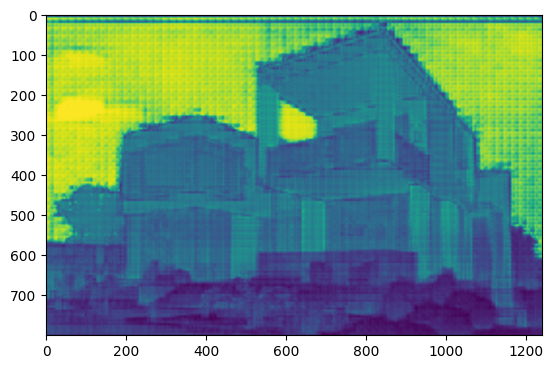

In [28]:
plt.imshow(pred_mask.squeeze(0))

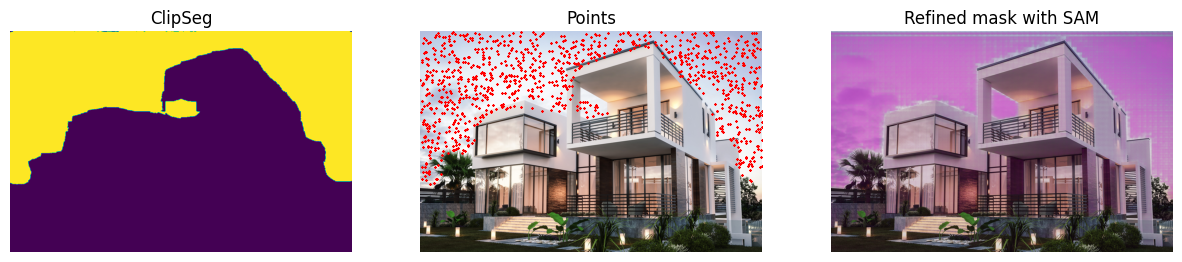

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
#clipseg
ax[0].imshow(pred)
ax[0].set_title('ClipSeg')
ax[0].axis('off')
#points
ax[1].imshow(img)
x,y = zip(*sampled_points)
ax[1].scatter(x,y,s=1,c='r',marker='x')
ax[1].set_title('Points')
ax[1].axis('off')
#sam
ax[2].imshow(img)
show_mask(pred_mask, ax[2], random_color=True)
ax[2].set_title('Refined mask with SAM')
ax[2].axis('off')
plt.show();

In [ ]:
pred2 = 